In [51]:
root_dir = '/home2/glee/dissertation/1_tech_gen_impact/class2class/Tech_Gen/'
master_dir = '/home2/glee/dissertation/1_tech_gen_impact/master/Tech_Gen/'
import sys
sys.path.append(root_dir)

import uspto
import json
import copy
import gc
import os
import argparse
import math
import time
import pickle
import re
import multiprocess as mp
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
sys.path.append("/share/tml_package")
from tml import utils
from scipy import io
from tqdm import tqdm
from collections import OrderedDict

import torch
from torch.nn import functional as F
from torch.nn import DataParallel as DP
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
from accelerate import Accelerator
import pytorch_model_summary

import optuna
from optuna.samplers import RandomSampler, TPESampler
from optuna.integration import SkoptSampler

import numpy as np
import pandas as pd
import scipy.stats
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from data import TechDataset, CVSampler
from models import Transformer, Predictor
from train_utils import EarlyStopping, perf_eval, objective_cv, build_model, train_model, validate_model_mp
from utils import token2class, DotDict, to_device

from cleantext.sklearn import CleanTransformer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# PART 1: Configuration

In [2]:
# analysis_date = "2023-05-04_1802" # Seminconductor
analysis_date = "2023-05-09_0331" # AI
args = argparse.Namespace(
    do_eval = True,
    do_save=False,
    config_file=os.path.join(root_dir, "configs", "USED_configs", "[CONFIGS]"+analysis_date+".json"),
    eval_train_set=False)

project_data_dir = os.path.join(master_dir, "data")
data_dir = os.path.join("/home2/glee/patent_data/data/")
model_dir = os.path.join(root_dir, "models")
result_dir = os.path.join(root_dir, "results")
config_dir = os.path.join(root_dir, "configs")

## parse configuration file
# args = parser.parse_args()
if args.config_file is not None:
    config_file = args.config_file
else:
    config_file = os.path.join(config_dir, "configs_light.json") if args.light else os.path.join(config_dir, "configs.json")
if args.do_eval: args.do_train = False
configs = DotDict().load(config_file)
org_config_keys = {key: list(configs[key].keys()) for key in configs.keys()}

# parse command line arguments
instant_configs = {key: value for (key, value) in vars(args).items() if value is not None} # if any argument passed when main.py executed
instant_configs_for_update = {configkey: {key: value for (key,value) in instant_configs.items() if key in org_config_keys[configkey]} for configkey in org_config_keys.keys()}
for key, value in configs.items():
    value.update(instant_configs_for_update[key])

## assign loss weights
if configs.model.model_type == "enc-pred-dec":
    configs.train.loss_weights["recon"] = configs.train.loss_weights["recon"] / sum(configs.train.loss_weights.values())
    configs.train.loss_weights["y"] = 1 - configs.train.loss_weights["recon"]
elif configs.model.model_type == "enc-pred":
    configs.train.loss_weights = {"recon": 0, "y": 1}
elif configs.model.model_type == "enc-dec":
    configs.train.loss_weights = {"recon": 1, "y": 0}

## assign devices
if configs.train.use_accelerator:
    accelerator = Accelerator()
    device_ids = list(range(torch.cuda.device_count()))
    device = accelerator.device
    configs.train.update({"accelerator": accelerator})
else:
    if torch.cuda.is_available():
        device_ids = list(range(torch.cuda.device_count()))
        gpu_usages = [np.sum([float(usage.split("uses")[-1].replace(" ","").replace("MB","")) for usage in torch.cuda.list_gpu_processes(id).split("GPU memory") if not usage=="" and "no processes are running" not in usage]) for id in device_ids]
        device_ids = np.argsort(gpu_usages)[:configs.train.n_gpus]
        device_ids = list(map(lambda x: torch.device('cuda', x),list(device_ids)))
        device = device_ids[0] # main device
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')
        device_ids = []

## extract configurations for dataset
config_period = "["+"-".join([str(year) for year in configs.data.target_period])+"]"
config_ipcs = str(configs.data.target_ipc).replace("\'","").replace(" ","")
config_keywords = str(configs.data.target_keywords).replace("\'","").replace(" ","")

## update configurations
configs.data.update({"root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "result_dir": result_dir,
                        "pretrained_enc": configs.model.pretrained_enc,
                        "pretrained_dec": configs.model.pretrained_dec,
                        "data_nrows": None,
                        "data_file": "collection_" + "".join([config_keywords, config_ipcs, config_period]) + ".csv"})
configs.train.update({"device": device,
                        "device_ids": device_ids,
                        "root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "use_keywords": configs.data.use_keywords,
                        "early_stop_patience": int(0.3*configs.train.max_epochs)})
configs.model.update({"device": device,
                        "device_ids": device_ids,
                        "n_directions": 2 if configs.model.bidirec else 1,
                        "use_accelerator": configs.train.use_accelerator})

## Set hyperparameters for model training (To be TUNED)
if configs.train.do_train and configs.train.do_tune:
    n_layers = configs.model.n_layers = None
    d_embedding = configs.model.d_embedding = None
    d_enc_hidden = configs.model.d_enc_hidden = None
    d_pred_hidden = configs.model.d_pred_hidden = None
    learning_rate = configs.train.learning_rate = None
    batch_size = configs.train.batch_size = None
    config_name = "HPARAM_TUNING"
    final_model_path = None
else:
    n_layers = configs.model.n_layers
    d_embedding = configs.model.d_embedding
    d_enc_hidden = configs.model.d_enc_hidden
    d_pred_hidden = configs.model.d_pred_hidden
    d_latent = configs.model.d_latent

    ## set filename for model
    key_components = {"data": ["ipc_level", "max_seq_len_class", "max_seq_len_claim", "vocab_size"], "model": ["n_layers", "d_hidden", "d_pred_hidden", "d_latent", "d_embedding", "d_ff", "n_head", "d_head"], "train": ["learning_rate", "batch_size", "max_epochs"]}
    model_config_name = "".join([config_keywords, config_ipcs, config_period]) + "data"
    for key in ["model", "train"]:
        for component in key_components[key]:
            model_config_name += f"[{str(configs[key][component])}]{component}"
    final_model_path = os.path.join(model_dir, f"[MODEL]{model_config_name}.ckpt")

configs.train.update({"model_config_name": model_config_name, "final_model_path": final_model_path})


# PART 2: Dataset setting

In [3]:
''' PART 2: Dataset setting '''
tstart = time.time()
dataset_config_name = "".join([config_keywords, config_ipcs, config_period]) + "data"
for component in key_components["data"]:
    dataset_config_name += f"[{str(configs.data[component])}]{component}"
dataset_path = os.path.join(project_data_dir, "pickled_dataset", "[DATASET]"+dataset_config_name+".pickle")

if os.path.exists(dataset_path) and args.do_save is False:
    print("Load pickled dataset...")
    with open(dataset_path, "rb") as f:
        tech_dataset = pickle.load(f)   # Load pickled dataset if dataset with same configuration already saved
        if tech_dataset.pretrained_enc != configs.data.pretrained_enc or tech_dataset.pretrained_dec != configs.data.pretrained_dec:
            tech_dataset.pretrained_enc = configs.data.pretrained_enc
            tech_dataset.pretrained_dec = configs.data.pretrained_dec
            tech_dataset.tokenizers = tech_dataset.get_tokenizers()
        for tk in tech_dataset.tokenizers.values():
            if "vocab_size" not in dir(tk):
                tk.vocab_size = tk.get_vocab_size()
        tech_dataset.use_keywords = configs.data.use_keywords
        ## load saved rawdata
        if tech_dataset.rawdata is None:
            tech_dataset.rawdata = pd.read_csv(os.path.join(data_dir, configs.data.data_file), low_memory=False)
    print("Pickled dataset loaded")
else:
    print("Make dataset...")
    if args.debug:
        configs.data.update({"data_nrows": 1000})
        dataset_path += ".debug"
    tech_dataset = TechDataset(configs.data)
    if not args.debug:
        rawdata_for_save = copy.deepcopy(tech_dataset.rawdata)
        with open(dataset_path, "wb") as f:
            tech_dataset.rawdata = None
            pickle.dump(tech_dataset, f)
        tech_dataset.rawdata = rawdata_for_save
tend = time.time()
print(f"{np.round(tend-tstart,4)} sec elapsed for loading patents for class [{configs.data.target_ipc}]")

configs.model.update({"tokenizers": tech_dataset.tokenizers,
                    "n_enc_seq_claim": tech_dataset.max_seq_len_claim,
                    "n_dec_seq_claim": tech_dataset.max_seq_len_claim,
                    "n_enc_seq_class": tech_dataset.max_seq_len_class,
                    "n_dec_seq_class": tech_dataset.max_seq_len_class,
                    "n_outputs": 1 if configs.data.pred_type=="regression" else tech_dataset.n_outputs,
                    "i_padding": tech_dataset.tokenizers["class_enc"].pad_id})

Load pickled dataset...
Pickled dataset loaded
51.6277 sec elapsed for loading patents for class [['G06F']]


In [42]:
tech_dataset.__len__()

69050

## Inference

In [4]:
final_model_path

'/home2/glee/dissertation/1_tech_gen_impact/class2class/Tech_Gen/models/[MODEL][G06F][2007-2012]data[4]n_layers[32]d_hidden[8]d_pred_hidden[32]d_latent[128]d_embedding[16]d_ff[4]n_head[16]d_head[0.0005]learning_rate[256]batch_size[50]max_epochs.ckpt'

In [5]:
final_model = build_model(configs.model, tokenizers=tech_dataset.tokenizers)
if os.path.exists(final_model_path):
    best_states = torch.load(final_model_path, map_location=device)
else:
    raise Exception("Model need to be trained first")
converted_states = OrderedDict()
if torch.cuda.is_available():
    for k, v in best_states.items():
        if 'module' not in k:
            k = 'module.'+k
        else:
            k = k.replace('features.module.', 'module.features.')
        converted_states[k] = v
else:
    for k, v in best_states.items():
        if 'module.' in k:
            k = k.replace('module.', '')
#         else:
#             k = k.replace('features.module.', 'module.features.')
        converted_states[k] = v
        
final_model.load_state_dict(converted_states)

del best_states
del converted_states
torch.cuda.empty_cache()
print("Model successfully loaded")

Model successfully loaded


In [17]:
 if re.search("^1.", torch.__version__) is not None:
        model_size = sum(t.numel() for t in final_model.parameters())
        print(f"Model size: {model_size/1000**2:.1f}M paramaters")

Model size: 1.0M paramaters


In [30]:
result_path = os.path.join(root_dir, "results")

used_train_data = pd.read_excel(os.path.join(result_path, "[DATASET]"+analysis_date+".xlsx"), sheet_name="TRAIN_dataset")
used_test_data = pd.read_excel(os.path.join(result_path, "[DATASET]"+analysis_date+".xlsx"), sheet_name="TEST_dataset")
used_train_index = tech_dataset.data.index.get_indexer(pd.Index(used_train_data["number"]))
used_test_index = tech_dataset.data.index.get_indexer(pd.Index(used_test_data["number"]))

In [31]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [32]:
batch_size = 16

In [33]:
used_train_dataset = Subset(tech_dataset, used_train_index)
train_loader = DataLoader(used_train_dataset, batch_size=batch_size, drop_last=True)

In [38]:
zs, ys, preds = [], [], []
newzs = []
for batch_data in tqdm(train_loader):
    batch_data = to_device(batch_data, final_model.device)
    y = batch_data["targets"].cpu().detach().numpy()
    
    enc_outputs, z, mu, logvar = final_model.encode(batch_data["text_inputs"])
    pred_outputs = final_model.predictor(z)
    torch.cuda.empty_cache()

    zs.append(z.cpu().detach().numpy())
    ys.append(y)
    preds.append(pred_outputs.argmax(1).cpu().detach().numpy())
    
    torch.cuda.empty_cache()
                                                
zs = np.concatenate(zs)
ys = np.concatenate(ys)
preds = np.concatenate(preds)

100%|██████████| 3884/3884 [06:12<00:00, 10.44it/s]


In [43]:
import datetime
from nltk.translate.bleu_score import sentence_bleu
col_years = ["<1976"] + np.arange(1976,2023).astype(str).tolist()
latest_year = datetime.datetime.now().year - 1
n_TC = configs.data.n_TC

visualize = True

In [44]:
ref_config_period = "[2012-2017]"
ref_data_file = "collection_" + "".join([config_keywords, config_ipcs, ref_config_period]) + ".csv"
ref_configs = copy.deepcopy(configs)
ref_configs.data.update({"target_period": ref_config_period, "data_file": ref_data_file})
ref_dataset = TechDataset(ref_configs.data)




Tokenizer is trained and saved


In [45]:
used_rawdata = tech_dataset.rawdata.set_index("number")
total_data = pd.concat([tech_dataset.data, ref_dataset.data], axis=0)
total_rawdata = pd.concat([tech_dataset.rawdata.set_index("number"), ref_dataset.rawdata.set_index("number")], axis=0)

In [46]:
tech_dataset.data.shape

(69050, 8)

- Parts of the collected patent database

In [47]:
# sample_index = pd.Index(["7987362", "7613164", "7266663", "7266666", "8327354", "7769767"])
# sample_index = pd.Index(["7523443", "7965656", "8335889", "7324446", "8020096", "7860895"])
sample_index = pd.Index(["8068433","7600135","7739999","7164981","7392483","8001433"])

In [48]:
sample_index

Index(['8068433', '7600135', '7739999', '7164981', '7392483', '8001433'], dtype='object')

In [49]:
total_rawdata

,Unnamed: 0,granted_year,granted_date,application_year,application_date,assignee,main_cpc,sub_cpc,main_ipc,sub_ipc,...,2015,2016,2017,2018,2019,2020,2021,2022,claims_org,n_claims
number,,,,,,,,,,,,,,,,,,,,,
7876934,7876934,2011,2011-01-25,2005,2005-11-02,"Siemens Medical Solutions USA, Inc.",G06K9/6255;G06V10/772;G06T7/11,G06T2207/30048;Y10S128/922;G06T2207/10132;Y10S...,G06K9/00,NaN,...,1,3,1,1,3,3,2,0,1. A method for segmenting an organ comprising...,18
7987362,7987362,2011,2011-07-26,2006,2006-09-12,"Uniloc USA, Inc.",G06F21/445;G06F21/73,G06F2221/2129,H04L9/32,G06F11/00;G06F12/14;G11C29/00,...,0,0,0,0,0,0,0,0,1. A method encoded on a data storage medium a...,13
7518946,7518946,2009,2009-04-14,2007,2007-09-12,"Ricoh Company, Ltd.",G06F13/4243,NaN,G11C8/00,NaN,...,0,0,0,0,0,0,0,0,"1. A memory control device, comprising: a cloc...",15
7382164,7382164,2008,2008-06-03,2006,2006-12-20,"Wisepal Technologies, Inc.",H03K5/1252,NaN,G06F1/08,NaN,...,0,0,0,0,0,0,0,0,"1. A glitch suppressing apparatus, comprising:...",22
7613164,7613164,2009,2009-11-03,2004,2004-11-03,Alcatel,H04J3/0688,H04J3/0691,H04J3/06,H04L12/66;H04W68/00;H04L5/00;H04L7/00;G06F1/00,...,0,0,0,2,0,0,0,0,1. A method for generating an internal clock i...,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8868727,8868727,2014,2014-10-21,2010,2010-09-22,"Blue Stripe Software, Inc.",H04L41/069;G06F11/3495;G06F11/3476;H04L41/0686,G06F2201/875,G06F15/173,NaN,...,0,0,0,3,13,19,0,0,1. A method for monitoring application perform...,12
8274474,8274474,2012,2012-09-25,2006,2006-07-03,Sony Computer Entertainment Inc.,G06F3/0236,NaN,G09G5/00,NaN,...,0,0,0,0,0,0,0,0,1. A character input device for determining an...,9
8214890,8214890,2012,2012-07-03,2008,2008-08-27,Microsoft Corporation,H04L63/0823;H04L63/0853;H04L63/18;H04L9/3263;H...,H04L2209/805;H04L2209/56;H04L63/061;H04L2463/062,G06F15/16,NaN,...,2,1,1,17,20,24,0,1,1. A computer-implemented process for allowing...,20


In [50]:
tech_dataset.data["ipcs"].apply(lambda x: len(x)).describe()

count    69050.000000
mean         2.747096
std          1.252462
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         23.000000
Name: ipcs, dtype: float64

In [52]:
tech_dataset.data["TC5"].quantile(0.9)

14.0

In [53]:
tech_dataset.data["TC5"].describe()

count    69050.000000
mean         5.928834
std         12.282008
min          0.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        310.000000
Name: TC5, dtype: float64

In [54]:
total_rawdata.loc["8068433"]

Unnamed: 0                                                    8068433
granted_year                                                     2011
granted_date                                               2011-11-29
application_year                                                 2007
application_date                                           2007-11-26
                                          ...                        
2020                                                                2
2021                                                                0
2022                                                                0
claims_org          1. A computing device comprising: a network in...
n_claims                                                           19
Name: 8068433, Length: 68, dtype: object

In [55]:
sample_data = pd.concat([tech_dataset.data.loc[sample_index], tech_dataset.rawdata.set_index("number").loc[sample_index][["forward_refs", "granted_year", "application_year_forward_refs"]]], axis=1)[["claims", "ipcs", "forward_refs", "TC5", "granted_year", "application_year_forward_refs"]]

In [56]:
sample_data

,claims,ipcs,forward_refs,TC5,granted_year,application_year_forward_refs
8068433,1. A computing device comprising: a network in...,"[G08C17, H04L12, H04L29]",9386519;10853329;8885531;9288269;9268384;87314...,10,2011,2014;2017;2010;2013;2013;2012;2012;2011;2011;2...
7600135,"1. A processor, comprising: a software control...","[G06F01, G06F01, G06F09]",9032404;7844839;8261116;7849297;8145884;941164...,11,2009,2005;2007;2010;2005;2009;2014;2011;2012;2010;2...
7739999,1. A method to control combustion in a multi-c...,"[F02B03, F02M07, G06F07]",10202927;9708991;9708991;10113747;9845732;9903...,5,2010,2012;2014;2014;2015;2014;2016;2016;2015;2014;2...
7164981,1. A line pressure variable control method for...,"[G06F07, F16H61]",8150585;9488267;8958963;8170762;8170762;769974...,4,2007,2009;2012;2013;2008;2008;2006;2010
7392483,1. A method of dynamically transforming graphi...,"[G06F03, G06F03, G06F17]",9049179;9513882;8903954;8793305;8412675;941788...,54,2008,2012;2010;2011;2007;2006;2010;2011;2010;2019;2...
8001433,1. A method of making a circuit for scan testi...,"[G01R31, G06F17]",9507406;9183105;9684367;10296077,2,2011,2013;2013;2014;2016


*TC5는 application이 아니라 granted year 기준!

In [ ]:
sample_data

- Used dataset

In [57]:
tech_dataset.data["TC5"].describe()

count    69050.000000
mean         5.928834
std         12.282008
min          0.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        310.000000
Name: TC5, dtype: float64

In [58]:
used_test_data["TC5"].describe()

count    6905.000000
mean        5.839392
std        11.656828
min         0.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       183.000000
Name: TC5, dtype: float64

In [59]:
L1_criterion = tech_dataset.data["TC5"].quantile(0.9)

In [60]:
# used_test_data_TC = used_test_data[(used_test_data["TC5"]>0) & (used_test_data["TC5"]<L1_criterion)].reset_index()
used_test_data_TC = used_test_data[used_test_data["TC5"]!=0].reset_index()
used_test_index_TC = tech_dataset.data.index.get_indexer(pd.Index(used_test_data_TC["number"]))

In [61]:
tech_dataset.data.loc[sample_index[1]]

number                                                     7600135
main_ipc                                                    G06F01
sub_ipc                                           [G06F01, G06F09]
ipcs                                      [G06F01, G06F01, G06F09]
claims           1. A processor, comprising: a software control...
TC5                                                             11
TC5_digitized                                                    0
class                                                           82
Name: 7600135, dtype: object

In [62]:
tech_dataset.X_class[sample_index[1]]

['G06F01', 'G06F01', 'G06F09']

In [63]:
def tech_identify(idx=None):
    input_class = torch.tensor(tech_dataset.tokenizers["class_enc"].encode(tech_dataset.X_class[idx])).unsqueeze(0)
    input_claim = tech_dataset.tokenize(tech_dataset.tokenizers["claim_enc"], tech_dataset.X_claim[idx])
    input_claim = {k: v.unsqueeze(0) for k, v in input_claim.items()}
    batch_input = {"class": torch.tensor(input_class), "claim": input_claim}
    input_inf = to_device(batch_input, final_model.module.device)

    output_class = torch.tensor(tech_dataset.tokenizers["class_dec"].encode(tech_dataset.X_class[idx])).unsqueeze(0)
    batch_output = {"text_outputs": torch.tensor(output_class)}
    output_inf = to_device(batch_output, final_model.module.device)

    near_mean_idx = np.argsort(np.sum(abs(zs - np.mean(zs, axis=0)), axis=1))[:2500]
    near_mean_idx_ = np.union1d(near_mean_idx, np.random.choice(np.where(ys==1)[0], 50))
    enc_outputs, z, mu, logvar = final_model.module.encode(input_inf)
    org_z = copy.deepcopy(z.view(1,-1).cpu().detach().numpy())
    pred_outputs = final_model.module.predict(z)
    org_y = copy.deepcopy(pred_outputs.argmax(1).cpu().detach().numpy())
    dec_inputs = None

    tokenizer = tech_dataset.tokenizers["class_dec"]

    org_text = tokenizer.decode_batch(input_class.cpu().detach().numpy())[0]
    org_text = org_text[org_text.index(tokenizer.sos_token)+1:org_text.index(tokenizer.eos_token)]

    n_iter = 30
    step_size = 40

    optimised = False
    for i in range(n_iter):
        pred_outputs = final_model.module.predict(z)
        z.retain_grad()
        FC_estimated = np.round(np.exp(pred_outputs[0,1].item()), 4) # estimated forward citations
        FC_estimated_inv = np.round(np.exp(pred_outputs[0,0].item()), 4)

        L1_error = (1-torch.exp(pred_outputs[0,1]))
        L1_error.backward(retain_graph=True)

        grad_for_update = (step_size * z.grad)
        z_ = z - grad_for_update

        z.grad.zero_()
        dec_outputs = final_model.module.decode(z_, enc_outputs, dec_inputs=None)
        dec_outputs = dec_outputs.argmax(-1)

        tokenizer = tech_dataset.tokenizers["class_dec"]
        gen_text = tokenizer.decode_batch(dec_outputs.cpu().detach().numpy())[0]
        if tokenizer.eos_token in gen_text:
            gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:gen_text.index(tokenizer.eos_token)]
        else:
            gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:]
        if gen_text != []:
            gen_text = [gen_text[0]] + list(np.array(gen_text[1:])[np.unique(gen_text[1:], return_index=True)[1]])                
            gen_text = set(gen_text)
        else: continue

        print(f"<< Iteration {i+1} >>")
        print(f"Estimated prob. for L1 (L2): {FC_estimated} ({FC_estimated_inv})")
        print("Original class:\n",set(org_text),"\nGenerated class:\n", gen_text)                    

        if FC_estimated>=0.6:
            return
        else:
            z = z_

In [ ]:
# for idx in sample_index_techdataset:
#     print()
#     tech_identify(idx)

In [75]:
def breakdown(ipcs):
    return ([ipc[0] for ipc in ipcs], [ipc[:3] for ipc in ipcs], [ipc[:4] for ipc in ipcs], ipcs)

In [76]:
def validate_reliability(model=None, idx=None, L1_threshold=0.5, n_iter=30, step_size=40):
    cnt_nonexist = 0
    cnt_noFC = 0
    cnt_diverge = 0
    cnt_same_ipcs = 0
    
    input_class = torch.tensor(tech_dataset.tokenizers["class_enc"].encode(tech_dataset.X_class[used_test_index_TC][idx])).unsqueeze(0)
    input_claim = tech_dataset.tokenize(tech_dataset.tokenizers["claim_enc"], tech_dataset.X_claim[used_test_index_TC][idx])
    input_claim = {k: v.unsqueeze(0) for k, v in input_claim.items()}
    batch_input = {"class": torch.tensor(input_class), "claim": input_claim}
    input_inf = to_device(batch_input, model.device)

    output_class = torch.tensor(tech_dataset.tokenizers["class_dec"].encode(tech_dataset.X_class[used_test_index_TC][idx])).unsqueeze(0)
    batch_output = {"text_outputs": torch.tensor(output_class)}
    output_inf = to_device(batch_output, model.device)

    enc_outputs, z, mu, logvar = model.encode(input_inf)
    org_z = copy.deepcopy(z.view(1,-1).cpu().detach().numpy())
    pred_outputs = model.predict(z)
    org_y = copy.deepcopy(pred_outputs.argmax(1).cpu().detach().numpy())
    dec_inputs = None

    if used_test_data_TC.iloc[idx]["TC5"] > 0:
        forward_refs = used_rawdata.loc[used_test_data_TC.iloc[idx]["number"]]["forward_refs"].split(";")
        ref_info = total_data.loc[[ref for ref in forward_refs if ref in total_data.index]]
        if len(ref_info) == 0:
            cnt_nonexist += 1
            return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None
        else:
            ref_ipcs = ref_info["ipcs"].apply(lambda x: set(x))
            ref_FCs = ref_info["TC"+str(n_TC)]

            tokenizer = tech_dataset.tokenizers["class_dec"]
            
            org_text = tokenizer.decode_batch(input_class.cpu().detach().numpy())[0]
            org_text = org_text[org_text.index(tokenizer.sos_token)+1:org_text.index(tokenizer.eos_token)]
            if set(org_text)==set(np.concatenate(ref_ipcs.apply(lambda x: list(x)).values)):
                cnt_same_ipcs += 1

            inclusions = [None, None, None, None]
            higher_impacts = [None, None, None, None]
            similar_refs_out = [None, None, None, None]
            unsimilar_refs_out = [None, None, None, None]
            optimised = False
            for i in range(n_iter):
                pred_outputs = model.predict(z)
                z.retain_grad()
                FC_estimated = np.round(np.exp(pred_outputs[0,1].item()), 4) # estimated forward citations
                FC_estimated_inv = np.round(np.exp(pred_outputs[0,0].item()), 4)
                
                L1_error = (1-torch.exp(pred_outputs[0,1]))
                L1_error.backward(retain_graph=True)

                grad_for_update = (step_size * z.grad)
                z_ = z - grad_for_update

                z.grad.zero_()
                dec_outputs = model.decode(z_, enc_outputs, dec_inputs=None)
                dec_outputs = dec_outputs.argmax(-1)

                tokenizer = tech_dataset.tokenizers["class_dec"]
                gen_text = tokenizer.decode_batch(dec_outputs.cpu().detach().numpy())[0]
                if tokenizer.eos_token in gen_text:
                    gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:gen_text.index(tokenizer.eos_token)]
                else:
                    gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:]
                if gen_text != []:
                    gen_text = [gen_text[0]] + list(np.array(gen_text[1:])[np.unique(gen_text[1:], return_index=True)[1]])                
                    gen_text = set(gen_text)
                else: continue
                
                if FC_estimated>=L1_threshold:
                    optimised = True
    
                    gen_text_breakdown = breakdown(gen_text)
                    ref_ipcs_breakdown = (ref_ipcs.apply(lambda x: breakdown(x)[0]), ref_ipcs.apply(lambda x: breakdown(x)[1]), ref_ipcs.apply(lambda x: breakdown(x)[2]), ref_ipcs)
            
                    for i in range(4):
                        if inclusions[i] is not None: continue
                        temp_gen_text = gen_text_breakdown[i]
                        temp_ref_ipcs = ref_ipcs_breakdown[i]
                    
                        hit_index = temp_ref_ipcs.apply(lambda x: 1 if set(x)==set(temp_gen_text) else 0)==1
                        similar_refs = temp_ref_ipcs[hit_index].index
                        similar_refs_out[i] = similar_refs
                        unsimilar_refs = temp_ref_ipcs[~hit_index].index
                        unsimilar_refs_out[i] = unsimilar_refs
                        if len(similar_refs) == 0:
                            inclusions[i] = 0
                            higher_impacts[i] = None
                        elif len(unsimilar_refs) == 0:
                            inclusions[i] = 1
                            similar_mean_FC = np.mean(ref_FCs.loc[similar_refs])
                            if similar_mean_FC <= 0:
                                higher_impacts[i] = 0
                            else:
                                higher_impacts[i] = 1
                        else:
                            inclusions[i] = 1
                            similar_mean_FC = np.mean(ref_FCs.loc[similar_refs])
                            unsimilar_mean_FC = np.mean(ref_FCs.loc[unsimilar_refs])
                            if similar_mean_FC >= unsimilar_mean_FC:
                                if similar_mean_FC <= 0:
                                    higher_impacts[i] = None
                                else:
                                    higher_impacts[i] = 1
                            else:
                                higher_impacts[i] = 0
                    if None not in inclusions:
                        break
                z = z_
            if optimised:
                return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), {"index": idx, "patent_id": used_test_data_TC.iloc[idx]["number"], 
                         "org_text": org_text, "gen_text": gen_text, "ref_ipcs": ref_ipcs, "ref_FCs": ref_FCs,
                         "inclusions": inclusions, "higher_impacts": higher_impacts, 
                         "FC_estimated": FC_estimated,
                         "similar_refs": similar_refs_out, "unsimilar_refs": unsimilar_refs_out}
            else:
                cnt_diverge += 1
                return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None
    else:
        pass
        cnt_noFC += 1
        return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None

In [65]:
ref_ipcs_breakdown = (ref_ipcs.apply(lambda x: breakdown(x)[0]), ref_ipcs.apply(lambda x: breakdown(x)[1]), ref_ipcs.apply(lambda x: breakdown(x)[2]), ref_ipcs)

NameError: name 'ref_ipcs' is not defined

In [ ]:
ref_ipcs_breakdown[2]

- Load computed dict_out (validation)

In [77]:
load_dict_out = False
save_dict_out = True
L1_threshold = 0.3 # or None
n_iter = 30
step_size = 40
analysis_config = analysis_date + "_thre" + str(L1_threshold)
print(analysis_config)

2023-05-09_0331_thre0.3


In [78]:
if load_dict_out:
    with open("../results/validation/"+analysis_config+"/dict_out.pickle", "rb") as f:
        dict_out = pickle.load(f)
    print("dict_out loaded")
else:
    model = final_model.module if torch.cuda.is_available() else final_model
    cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs = 0, 0, 0, 0
    dict_out = {"index": [], "patent_id": [], "org_text": [], "gen_text": [], "ref_ipcs": [], "ref_FCs": [],
                "inclusions": [], "higher_impacts": [], "FC_estimated": [], "similar_refs": [], "unsimilar_refs": []}
    for idx in tqdm(range(len(used_test_index_TC))):
#     for idx in tqdm(range(500)):
        cnts, results = validate_reliability(model=model, idx=idx, L1_threshold=L1_threshold, n_iter=n_iter, step_size=step_size)
        cnt_nonexist += cnts[0]
        cnt_noFC += cnts[1]
        cnt_diverge += cnts[2]
        cnt_same_ipcs += cnts[3]
        if results is not None:
            for k,v in results.items():
                dict_out[k].append(v)
    for k, v in dict_out.items():
        dict_out[k] = np.array(v)
    dict_out["cnts"] = {"cnt_nonexist": cnt_nonexist, "cnt_noFC": cnt_noFC, 
                "cnt_diverge": cnt_diverge, "cnt_same_ipcs": cnt_same_ipcs}
    
    if save_dict_out:
        with open("../results/validation/"+analysis_config+"/dict_out.pickle", "wb") as f:
            pickle.dump(dict_out, f)

100%|██████████| 5205/5205 [06:16<00:00, 13.81it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../results/validation/2023-05-09_0331_thre0.3/dict_out.pickle'

In [87]:
os.path.exists(fname_to_save)

False

In [86]:
fname_to_save = "../results/validation/"+analysis_config+"/dict_out.pickle"

In [88]:
if save_dict_out:
    dir_to_save = "../results/validation/"+analysis_config
    if not os.path.exists(dir_to_save):
        os.mkdir(dir_to_save)
    with open(dir_to_save+"/dict_out.pickle", "wb") as f:
        pickle.dump(dict_out, f)

In [94]:
dict_out["org_text"]

array([list(['G10L15', 'G06F07', 'G10L15']), list(['G06F09', 'G06F09']),
       list(['G06K09', 'H04N05', 'H04N09']), ...,
       list(['G06F07', 'G06K15']), list(['G06F03', 'G06F03', 'G06F09']),
       list(['G06F07', 'G06F17'])], dtype=object)

In [92]:
dict_out["gen_text"]

array([{'G10L15'}, {'G06F09'}, {'H04N05', 'H04N09', 'G06K09'}, ...,
       {'G06F19', 'G06F07'}, {'G06F03'}, {'G06F17', 'G06F07'}],
      dtype=object)

In [95]:
ipcs_comparison = pd.concat([pd.Series(dict_out["org_text"]).apply(lambda x: set(x)), pd.Series(dict_out["gen_text"]).apply(lambda x: set(x))], axis=1)

In [96]:
ipcs_comparison

,0,1
0,"{G10L15, G06F07}",{G10L15}
1,{G06F09},{G06F09}
2,"{H04N05, H04N09, G06K09}","{H04N05, H04N09, G06K09}"
3,"{G06F17, G06F07}","{G06F17, G06F07}"
4,"{G06F03, H04N07}","{G06F03, H04N07}"
...,...,...
4145,"{G06F09, G06F03, G06F13}","{G06F09, G06F03, G06F13}"
4146,"{G06F09, G06F15, G06F07}","{G06F09, G06F15, G06F07}"
4147,"{G06F07, G06K15}","{G06F19, G06F07}"
4148,"{G06F09, G06F03}",{G06F03}


In [97]:
ipcs_comparison.iloc[2][0] == ipcs_comparison.iloc[2][1]

True

In [98]:
n_differentiated = ipcs_comparison.apply(lambda x: 1 if x[0]!=x[1] else 0, axis=1).sum()

In [99]:
n_differentiated / len(ipcs_comparison)

0.4831325301204819

In [100]:
print("#total:",len(used_test_index_TC))
print("#valid data:",len(dict_out["index"]))
print("#nonexist data:",dict_out["cnts"]["cnt_nonexist"])
print("#no forward citations:",dict_out["cnts"]["cnt_noFC"])
print("#diverged:",dict_out["cnts"]["cnt_diverge"])
print("#same ipcs:",dict_out["cnts"]["cnt_same_ipcs"])
print("\n")
for i in range(3,4):
    inclusions = np.array(dict_out["inclusions"])[:,i]
    ratio_included = np.round(len(inclusions[inclusions==1])/len(inclusions), 4)
    higher_impacts = np.array(dict_out["higher_impacts"])[:,i][np.array(dict_out["higher_impacts"])[:,i] != None]
    ratio_higher_impact = np.round(len(higher_impacts[higher_impacts==1])/len(higher_impacts), 4)
    print(f"for level {i+1}, Ratio generated IPCs are included in citing patents: {ratio_included}")
    print(f"for level {i+1}, Ratio generated IPCs have higher impact than other citing patents: {ratio_higher_impact}")
    print("\n")

#total: 5205
#valid data: 4150
#nonexist data: 1048
#no forward citations: 0
#diverged: 7
#same ipcs: 185


for level 4, Ratio generated IPCs are included in citing patents: 0.1583
for level 4, Ratio generated IPCs have higher impact than other citing patents: 0.4984




In [101]:
temp_inclusions = np.array(dict_out["inclusions"])[np.array(dict_out["inclusions"])[:,-1]==0]

In [102]:
temp_inclusions = np.array(dict_out["inclusions"])[np.array(dict_out["inclusions"])[:,-1]==0]
for i in range(3):
    temp_ratio = len(temp_inclusions[temp_inclusions[:,i]==0]) / len(temp_inclusions)
    print(f"for level {i+1}, Hit ratio when level 4 is not hit: {np.round(temp_ratio,4)}")

for level 1, Hit ratio when level 4 is not hit: 0.2648
for level 2, Hit ratio when level 4 is not hit: 0.4286
for level 3, Hit ratio when level 4 is not hit: 0.6018


In [103]:
from scipy.stats import ttest_ind
whole_patent_classes = tech_dataset.data["ipcs"].apply(lambda x: set(x))

hit_similar_FCs, hit_unsimilar_FCs, hit_diff_FCs = [], [], []
hit_similar_FCs_mean, hit_unsimilar_FCs_mean = [], []
hit_similar_FCs_rank = []
whole_FC_ttest = {"statistic": [], "pvalue": []}
whole_FCs_diff = []
hit_samples_index = dict_out["inclusions"][:,-1]==1

hit_patent_ids = dict_out["patent_id"][hit_samples_index]
hit_similar_refs = dict_out["similar_refs"][hit_samples_index][:,-1]
hit_unsimilar_refs = dict_out["unsimilar_refs"][hit_samples_index][:,-1]
for i in range(len(hit_patent_ids)):
    hit_FCs = dict_out["ref_FCs"][hit_samples_index][i]
    hit_FCs = hit_FCs.loc[~hit_FCs.index.duplicated(keep="first")]
    hit_similar_FC = hit_FCs.loc[hit_similar_refs[i].drop_duplicates()]
    hit_similar_FC_rank = hit_FCs.rank(pct=True).loc[hit_similar_refs[i].drop_duplicates()]
    hit_unsimilar_FC = hit_FCs.loc[hit_unsimilar_refs[i].drop_duplicates()]
    if len(hit_unsimilar_FC)>0:
        hit_diff_FC = hit_similar_FC.mean() - hit_unsimilar_FC.mean()
    else:
        hit_diff_FC = hit_similar_FC.mean()
    
    org_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["org_text"][hit_samples_index][i])].index]["TC5"]
    gen_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["gen_text"][hit_samples_index][i])].index]["TC5"]
    if len(org_whole_FC)>0:
        whole_FC_diff = gen_whole_FC.mean() - org_whole_FC.mean()
    else:
        whole_FC_diff = gen_whole_FC.mean()
    
    hit_similar_FCs.append(hit_similar_FC)
    hit_similar_FCs_rank.append(hit_similar_FC_rank)
    hit_similar_FCs_mean.append(hit_similar_FC.mean())
    hit_unsimilar_FCs.append(hit_unsimilar_FC)
    if len(hit_unsimilar_FC)>0:
        hit_unsimilar_FCs_mean.append(hit_unsimilar_FC.mean())
    else:
        hit_unsimilar_FCs_mean.append(0)
    hit_diff_FCs.append(hit_diff_FC)
    
    ttest_res = ttest_ind(gen_whole_FC, org_whole_FC, equal_var=False)
    
    whole_FC_ttest["statistic"].append(ttest_res.statistic)
    whole_FC_ttest["pvalue"].append(ttest_res.pvalue)
    if set(dict_out["org_text"][hit_samples_index][i]) != set(dict_out["gen_text"][hit_samples_index][i]):
        whole_FCs_diff.append(whole_FC_diff)
    
hit_similar_FCs = np.concatenate(hit_similar_FCs)
hit_similar_FCs_rank = np.concatenate(hit_similar_FCs_rank)
hit_similar_FCs_mean = np.array(hit_similar_FCs_mean)
hit_unsimilar_FCs = np.concatenate(hit_unsimilar_FCs)
hit_unsimilar_FCs_mean = np.array(hit_unsimilar_FCs_mean)
hit_diff_FCs = np.array(hit_diff_FCs)

print("Distribution of forward citations (hit)\n",pd.Series(hit_similar_FCs).describe(),"\n")
print("Distribution of forward citations (not hit)\n",pd.Series(hit_unsimilar_FCs).describe(),"\n")
print("Distribution of mean forward citations (hit)\n",pd.Series(hit_similar_FCs_mean).describe(),"\n")
print("Distribution of mean forward citations (not hit)\n",pd.Series(hit_unsimilar_FCs_mean).describe(),"\n")
print("Distribution of difference of forward citations\n",pd.Series(hit_diff_FCs).describe(),"\n")

/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Distribution of forward citations (hit)
 count    1455.000000
mean        7.712715
std        15.151139
min         0.000000
25%         0.000000
50%         3.000000
75%         8.000000
max       202.000000
dtype: float64 

Distribution of forward citations (not hit)
 count    5694.000000
mean       15.168950
std        34.533883
min         0.000000
25%         1.000000
50%         3.000000
75%        12.000000
max       425.000000
dtype: float64 

Distribution of mean forward citations (hit)
 count    657.000000
mean       6.008552
std        9.468174
min        0.000000
25%        1.000000
50%        2.500000
75%        6.500000
max       55.666667
dtype: float64 

Distribution of mean forward citations (not hit)
 count    657.000000
mean       6.217299
std       12.152259
min        0.000000
25%        0.333333
50%        2.571429
75%        6.750000
max      143.300000
dtype: float64 

Distribution of difference of forward citations
 count    657.000000
mean      -0.208747
std  

In [104]:
cnt_same, cnt_diff = 0, 0
ranks_same, ranks_diff = [], []
value_same, value_diff = [], []
org_patents_same, org_patents_diff = [], []
cols_val = ["patent_id", "org_ipcs", "org_FC", "gen_ipcs", "is_same", 
            "forward_ref", "ref_ipcs", "ref_FC", "ref_FC_rank"]
df_val = pd.DataFrame(columns=cols_val)
hit_similar_refs = dict_out["similar_refs"][hit_samples_index][:,-1]

for i in tqdm(range(len(dict_out["ref_ipcs"][hit_samples_index]))):
    pid = dict_out["patent_id"][hit_samples_index][i]
    org_FC = tech_dataset.data.loc[pid]["TC5"]
    orgs = set(dict_out["org_text"][dict_out["inclusions"][:,-1]==1][i])
    gens = set(dict_out["gen_text"][dict_out["inclusions"][:,-1]==1][i])
    is_same = 1 if orgs==gens or orgs.union(gens)==orgs else 0
    hit_FCs = dict_out["ref_FCs"][hit_samples_index][i]
    hit_FCs = hit_FCs.loc[~hit_FCs.index.duplicated(keep="first")]
    hit_similar_FC = hit_FCs.loc[hit_similar_refs[i][hit_similar_refs[i].duplicated()]]
#     hit_similar_FC = hit_similar_FC.drop_duplicates()
    hit_similar_FC_rank = hit_FCs.rank(pct=True).loc[hit_similar_refs[i][hit_similar_refs[i].duplicated()]]
#     hit_similar_FC_rank = hit_similar_FC_rank.drop_duplicates()
    
    for ref in hit_similar_refs[i].drop_duplicates():
        ref_ipcs = dict_out["ref_ipcs"][hit_samples_index][i].loc[ref]
        if isinstance(ref_ipcs, pd.Series): ref_ipcs = ref_ipcs[0]
        hit_similar_FC = hit_FCs.loc[ref]
        if isinstance(hit_similar_FC, pd.Series): hit_similar_FC = hit_similar_FC[0]
        hit_similar_FC_rank = hit_FCs.rank(pct=True).loc[ref]
        if isinstance(hit_similar_FC_rank, pd.Series): hit_similar_FC_rank = hit_similar_FC_rank[0]
        
        df_container = pd.DataFrame([[pid, orgs, org_FC, gens, is_same, ref, ref_ipcs, hit_similar_FC, hit_similar_FC_rank]], columns=cols_val)
        df_val = pd.concat([df_val, df_container])

df_val = df_val.set_index("patent_id")

100%|██████████| 657/657 [00:03<00:00, 185.14it/s]


In [105]:
df_val.loc[:,"ref_FC_new"] = df_val.apply(lambda x: str(x["ref_FC"])+" ("+str(np.round(x["ref_FC_rank"],2))+")", axis=1)

In [106]:
df_val

,org_ipcs,org_FC,gen_ipcs,is_same,forward_ref,ref_ipcs,ref_FC,ref_FC_rank,ref_FC_new
patent_id,,,,,,,,,
7523443,{G06F09},1,{G06F09},1,9652207,{G06F09},4,0.750000,4 (0.75)
7523443,{G06F09},1,{G06F09},1,9639335,{G06F09},1,0.500000,1 (0.5)
7523443,{G06F09},1,{G06F09},1,9696974,{G06F09},12,1.000000,12 (1.0)
7523443,{G06F09},1,{G06F09},1,9563412,{G06F09},0,0.250000,0 (0.25)
7418663,"{G06F03, G06F17, G06F07}",20,"{G06F03, G06F17}",1,9678933,"{G06F03, G06F17}",2,0.229730,2 (0.23)
...,...,...,...,...,...,...,...,...,...
7325002,"{G06F17, G06F07}",7,"{G06F17, G06F07}",1,7904479,"{G06F17, G06F07}",15,1.000000,15 (1.0)
8159971,"{H04L12, G06F15}",1,"{H04L12, G06F15}",1,9237073,"{H04L12, G06F15}",0,1.000000,0 (1.0)
7860895,"{G06F17, G06F07}",26,"{G06F17, G06F07}",1,8793265,"{G06F17, G06F07}",13,0.714286,13 (0.71)


In [107]:
L1_criterion = tech_dataset.data["TC5"].quantile(0.9)
print("total hit:", len(df_val))
print("same:",len(df_val[df_val["is_same"]==1]))
print("diff:",len(df_val[df_val["is_same"]==0]))
print("over L1 criterion:", len(df_val[df_val["is_same"]==0][df_val[df_val["is_same"]==0]["ref_FC"]>=L1_criterion]))
print("ratio:",len(df_val[df_val["is_same"]==0][df_val[df_val["is_same"]==0]["ref_FC"]>=L1_criterion]) / len(df_val[df_val["is_same"]==0]))

total hit: 1455
same: 1404
diff: 51
over L1 criterion: 11
ratio: 0.21568627450980393


In [108]:
## 인용 IPC 중 생성 IPC와 동일한 게 있으면서, 입력 IPC와 생성 IPC가 다르고, 피인용수가 전체 데이터셋의 L1 기준인 9 이상인 샘플
df_val[df_val["is_same"]==0][df_val[df_val["is_same"]==0]["ref_FC"]>=L1_criterion].drop(labels=["is_same", "ref_FC", "ref_FC_rank"], axis=1)

,org_ipcs,org_FC,gen_ipcs,forward_ref,ref_ipcs,ref_FC_new
patent_id,,,,,,
7992129,"{G06F09, G06F19, G06F03}",3,"{G06F09, G06F17}",9235395,"{G06F09, G06F17}",29 (1.0)
7249951,"{G09G05, G09B23}",13,"{G06F03, G09G05}",8922503,"{G06F03, G09G05}",20 (0.77)
7249951,"{G09G05, G09B23}",13,"{G06F03, G09G05}",8547339,"{G06F03, G09G05}",49 (0.86)
7249951,"{G09G05, G09B23}",13,"{G06F03, G09G05}",8947383,"{G06F03, G09G05}",21 (0.79)
7249951,"{G09G05, G09B23}",13,"{G06F03, G09G05}",9035898,"{G06F03, G09G05}",17 (0.73)
7249951,"{G09G05, G09B23}",13,"{G06F03, G09G05}",8587548,"{G06F03, G09G05}",31 (0.84)
7665088,"{G06F09, G06F13}",23,"{G06F09, G06F15}",8631066,"{G06F09, G06F15}",19 (0.89)
7613375,"{G02B06, G09G05}",2,"{G06F03, G09G05}",8963886,"{G06F03, G09G05}",26 (1.0)
7325199,{G06F03},38,"{G06F03, H04N07}",7877690,"{G06F03, H04N07}",37 (0.92)


In [109]:
## 인용 IPC 중 생성 IPC와 동일하면서, 입력 IPC와는 다르고, 피인용수가 입력 특허보다 많은 샘플
df_val[df_val["is_same"]==0].drop(labels=["is_same", "ref_FC", "ref_FC_rank"], axis=1).apply(lambda x: x.name if int(x["org_FC"]) <= int(x["ref_FC_new"].split("(")[0]) else np.nan, axis=1).dropna().shape

(13,)

**5.1 in-depth 사례를 4.3으로 옮기기 위해, iteration 과정 추출 (231018)**

7600135

In [59]:
idx = dict_out["index"][np.where(dict_out["patent_id"]=="7600135")[0][0]]

In [64]:
tech_dataset.data.iloc[used_test_index_TC[idx]]

number                                                     7600135
main_ipc                                                    G06F01
sub_ipc                                           [G06F01, G06F09]
ipcs                                      [G06F01, G06F01, G06F09]
claims           1. A processor, comprising: a software control...
TC5                                                             11
TC5_digitized                                                    0
class                                                           82
Name: 7600135, dtype: object

In [66]:
model = final_model.module if torch.cuda.is_available() else final_model

In [132]:
input_class = torch.tensor(tech_dataset.tokenizers["class_enc"].encode(tech_dataset.X_class[used_test_index_TC][idx])).unsqueeze(0)
input_claim = tech_dataset.tokenize(tech_dataset.tokenizers["claim_enc"], tech_dataset.X_claim[used_test_index_TC][idx])
input_claim = {k: v.unsqueeze(0) for k, v in input_claim.items()}
batch_input = {"class": torch.tensor(input_class), "claim": input_claim}
input_inf = to_device(batch_input, model.device)

output_class = torch.tensor(tech_dataset.tokenizers["class_dec"].encode(tech_dataset.X_class[used_test_index_TC][idx])).unsqueeze(0)
batch_output = {"text_outputs": torch.tensor(output_class)}
output_inf = to_device(batch_output, model.device)

In [422]:
forward_refs = used_rawdata.loc[used_test_data_TC.iloc[idx]["number"]]["forward_refs"].split(";")
ref_info = total_data.loc[[ref for ref in forward_refs if ref in total_data.index]]
if len(ref_info) == 0:
    pass
else:
    ref_ipcs = ref_info["ipcs"].apply(lambda x: set(x))
    ref_FCs = ref_info["TC"+str(n_TC)]

In [454]:
idx = dict_out["index"][np.where(dict_out["patent_id"]=="7636945")[0][0]]

In [455]:
tech_dataset.data.iloc[used_test_index_TC[idx]]

number                                                     7636945
main_ipc                                                    G06F11
sub_ipc                                           [G06F09, G06F12]
ipcs                                      [G06F11, G06F09, G06F12]
claims           1. A method of detecting script language virus...
TC5                                                              7
TC5_digitized                                                    0
class                                                           82
Name: 7636945, dtype: object

7636945

In [456]:
model = final_model.module if torch.cuda.is_available() else final_model

In [457]:
input_class = torch.tensor(tech_dataset.tokenizers["class_enc"].encode(tech_dataset.X_class[used_test_index_TC][idx])).unsqueeze(0)
input_claim = tech_dataset.tokenize(tech_dataset.tokenizers["claim_enc"], tech_dataset.X_claim[used_test_index_TC][idx])
input_claim = {k: v.unsqueeze(0) for k, v in input_claim.items()}
batch_input = {"class": torch.tensor(input_class), "claim": input_claim}
input_inf = to_device(batch_input, model.device)

output_class = torch.tensor(tech_dataset.tokenizers["class_dec"].encode(tech_dataset.X_class[used_test_index_TC][idx])).unsqueeze(0)
batch_output = {"text_outputs": torch.tensor(output_class)}
output_inf = to_device(batch_output, model.device)

In [458]:
forward_refs = used_rawdata.loc[used_test_data_TC.iloc[idx]["number"]]["forward_refs"].split(";")
ref_info = total_data.loc[[ref for ref in forward_refs if ref in total_data.index]]
if len(ref_info) == 0:
    pass
else:
    ref_ipcs = ref_info["ipcs"].apply(lambda x: set(x))
    ref_FCs = ref_info["TC"+str(n_TC)]

In [459]:
while 1:
    i = 0
    enc_outputs, z, mu, logvar = model.encode(input_inf)
    pred_outputs = model.predict(z)

    dec_outputs = model.decode(z, enc_outputs, dec_inputs=None)
    dec_outputs = dec_outputs.argmax(-1)

    tokenizer = tech_dataset.tokenizers["class_dec"]
    gen_text = tokenizer.decode_batch(dec_outputs.cpu().detach().numpy())[0]

    if tokenizer.eos_token in gen_text:
        gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:gen_text.index(tokenizer.eos_token)]
    else:
        gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:]
    if gen_text != []:
        gen_text = [gen_text[0]] + list(np.array(gen_text[1:])[np.unique(gen_text[1:], return_index=True)[1]])                
        gen_text = set(gen_text)

    FC_estimated = np.round(np.exp(pred_outputs[0,1].item()), 4)
    if FC_estimated > 0.5: continue

    print(f"Iteration 0, Generated IPC {gen_text}, L1 prob {FC_estimated}")

    inclusions = [None, None, None, None]
    higher_impacts = [None, None, None, None]
    similar_refs_out = [None, None, None, None]
    unsimilar_refs_out = [None, None, None, None]

    optimised = False
    for i in range(1,n_iter+1):
        pred_outputs = model.predict(z)
        z.retain_grad()
        L1_error = (1-torch.exp(pred_outputs[0,1]))
        L1_error.backward(retain_graph=True)
        grad_for_update = (step_size * z.grad)
        z_ = z - grad_for_update

        z.grad.zero_()
        dec_outputs = model.decode(z_, enc_outputs, dec_inputs=None)
        dec_outputs = dec_outputs.argmax(-1)

        pred_outputs_ = model.predict(z_)
        FC_estimated = np.round(np.exp(pred_outputs_[0,1].item()), 4) # estimated forward citations
        FC_estimated_inv = np.round(np.exp(pred_outputs_[0,0].item()), 4)

        tokenizer = tech_dataset.tokenizers["class_dec"]
        gen_text = tokenizer.decode_batch(dec_outputs.cpu().detach().numpy())[0]
        if tokenizer.eos_token in gen_text:
            gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:gen_text.index(tokenizer.eos_token)]
        else:
            gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:]
        if gen_text != []:
            gen_text = [gen_text[0]] + list(np.array(gen_text[1:])[np.unique(gen_text[1:], return_index=True)[1]])                
            gen_text = set(gen_text)
        else: continue

        print(f"Iteration {i}, Generated IPC {gen_text}, L1 prob {FC_estimated}")

        z = z_

        if FC_estimated>=L1_threshold:
            optimised = True
            
    break

Iteration 0, Generated IPC {'G06F12', 'G06F11'}, L1 prob 0.4822
Iteration 1, Generated IPC {'G08B23', 'G06F12', 'G06F11'}, L1 prob 0.8113
Iteration 2, Generated IPC {'G08B23', 'G06F12', 'G06F11'}, L1 prob 0.8822
Iteration 3, Generated IPC {'G08B23', 'G06F12', 'G06F11'}, L1 prob 0.9161
Iteration 4, Generated IPC {'G08B23', 'G06F12', 'G06F11'}, L1 prob 0.9351
Iteration 5, Generated IPC {'G08B23', 'G06F12', 'G06F11'}, L1 prob 0.9473
Iteration 6, Generated IPC {'H04J01', 'G06F12', 'G06F15', 'G06F11'}, L1 prob 0.9556
Iteration 7, Generated IPC {'G06F17', 'G08B23', 'H04J01', 'G06F15', 'G06F11', 'G06F12'}, L1 prob 0.9617
Iteration 8, Generated IPC {'G08B23', 'G06F12', 'H04J01', 'G06F11'}, L1 prob 0.9663
Iteration 9, Generated IPC {'G06F17', 'H04J01', 'G06F15', 'G06F11', 'G06F13', 'G06F12'}, L1 prob 0.97
Iteration 10, Generated IPC {'G08B23', 'H04J01', 'G06F15', 'G06F11', 'G06F13', 'G06F12'}, L1 prob 0.9729
Iteration 11, Generated IPC {'G08B23', 'H04J01', 'G06F15', 'G06F11', 'G06F13', 'G06F12'

In [451]:
df_val[df_val["is_same"]==0][df_val[df_val["is_same"]==0]["ref_FC"]>=L1_criterion]["ref_FC"].astype(int).describe()

count     12.000000
mean      53.916667
std       41.238681
min       17.000000
25%       22.750000
50%       37.000000
75%       68.500000
max      139.000000
Name: ref_FC, dtype: float64

In [452]:
df_val[df_val["is_same"]==0][df_val[df_val["is_same"]==0]["ref_FC"]>=L1_criterion]["ref_FC_rank"].describe()

count    12.000000
mean      0.874570
std       0.255294
min       0.130952
25%       0.854167
50%       1.000000
75%       1.000000
max       1.000000
Name: ref_FC_rank, dtype: float64

In [453]:
# ## 인용 IPC 중 생성 IPC와 동일한 게 있으면서, 입력 IPC와 생성 IPC가 다르고, 피인용수가 전체 데이터셋의 L1 기준인 9 이상인 샘플
# df_val[df_val["is_same"]==0][df_val[df_val["is_same"]==0]["ref_FC"]>=L1_criterion]

- Patent_matched 전체

In [454]:
df_val["ref_FC"].astype(float).describe()

count    1353.000000
mean        7.876571
std        16.232510
min         0.000000
25%         0.000000
50%         3.000000
75%         7.000000
max       202.000000
Name: ref_FC, dtype: float64

In [455]:
df_val["ref_FC_rank"].astype(float).describe()

count    1353.000000
mean        0.605580
std         0.284482
min         0.032143
25%         0.375000
50%         0.602564
75%         0.857143
max         1.000000
Name: ref_FC_rank, dtype: float64

<AxesSubplot:>

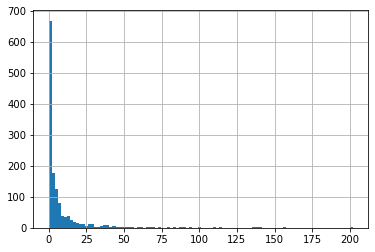

In [456]:
df_val["ref_FC"].astype(float).hist(bins=100)

<AxesSubplot:>

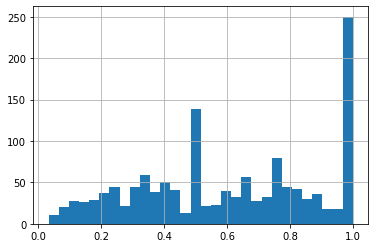

In [457]:
df_val["ref_FC_rank"].astype(float).hist(bins=30)

- IPC_original == IPC_identified

In [52]:
df_val[df_val["is_same"]==1]["ref_FC"].astype(int).describe()

count    662.000000
mean       6.110272
std       16.366036
min        0.000000
25%        0.000000
50%        2.000000
75%        5.000000
max      152.000000
Name: ref_FC, dtype: float64

In [53]:
df_val[df_val["is_same"]==1]["ref_FC_rank"].astype(float).describe()

count    662.000000
mean       0.634517
std        0.286946
min        0.032258
25%        0.384615
50%        0.666667
75%        0.909284
max        1.000000
Name: ref_FC_rank, dtype: float64

<AxesSubplot:>

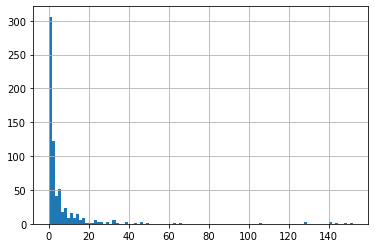

In [54]:
df_val[df_val["is_same"]==1]["ref_FC"].astype(float).hist(bins=100)

<AxesSubplot:>

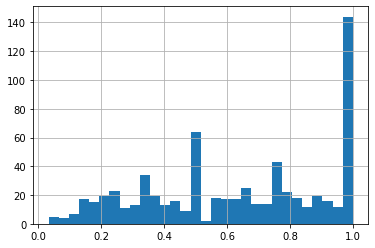

In [55]:
df_val[df_val["is_same"]==1]["ref_FC_rank"].astype(float).hist(bins=30)

- IPC_original != IPC_identified

In [56]:
df_val[df_val["is_same"]==0]["ref_FC"].astype(int).describe()

count     37.00000
mean      10.27027
std       24.80104
min        0.00000
25%        0.00000
50%        0.00000
75%       12.00000
max      133.00000
Name: ref_FC, dtype: float64

In [57]:
df_val[df_val["is_same"]==0]["ref_FC_rank"].astype(float).describe()

count    37.000000
mean      0.551982
std       0.319979
min       0.020000
25%       0.363636
50%       0.363636
75%       0.920000
max       1.000000
Name: ref_FC_rank, dtype: float64

<AxesSubplot:>

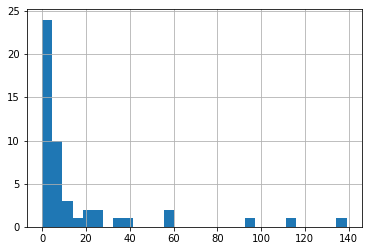

In [464]:
df_val[df_val["is_same"]==0]["ref_FC"].astype(float).hist(bins=30)

<AxesSubplot:>

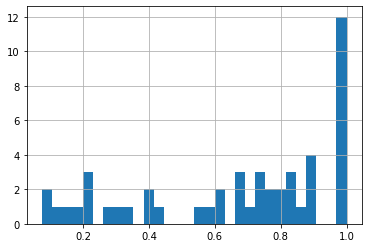

In [465]:
df_val[df_val["is_same"]==0]["ref_FC_rank"].astype(float).hist(bins=30)

In [466]:
df_val_adv = df_val[df_val.apply(lambda x: True if x["org_FC"]<=x["ref_FC"] else False, axis=1)]

In [58]:
L1_criterion = tech_dataset.data["TC5"].quantile(0.9)
print("total hit:", len(df_val_adv))
print("same:",len(df_val_adv[df_val_adv["is_same"]==1]))
print("diff:",len(df_val_adv[df_val_adv["is_same"]==0]))
print("over L1 criterion:", len(df_val_adv[df_val_adv["is_same"]==0][df_val_adv[df_val_adv["is_same"]==0]["ref_FC"]>=L1_criterion]))
print("ratio:",len(df_val_adv[df_val_adv["is_same"]==0][df_val_adv[df_val_adv["is_same"]==0]["ref_FC"]>=L1_criterion]) / len(df_val_adv[df_val_adv["is_same"]==0]))

NameError: name 'df_val_adv' is not defined

In [468]:
## 인용 IPC 중 생성 IPC와 동일한 게 있으면서, 입력 IPC와 생성 IPC가 다르고, 피인용수가 전체 데이터셋의 L1 기준인 9 이상이며, 인용 특허의 피인용 수가 입력 특허보다 많은 샘플
df_val_adv[df_val_adv["is_same"]==0][df_val_adv[df_val_adv["is_same"]==0]["ref_FC"]>=L1_criterion]

,org_ipcs,org_FC,gen_ipcs,is_same,forward_ref,ref_ipcs,ref_FC,ref_FC_rank,ref_FC_new
patent_id,,,,,,,,,
7240223,{G06F01},12,"{G06F01, G06F15}",0,7647516,"{G06F01, G06F15}",24,1.000,24 (1.0)
7600135,"{G06F01, G06F09}",11,"{G06F01, G06F15, G06F09}",0,7844839,"{G06F01, G06F15, G06F09}",35,1.000,35 (1.0)
7613375,"{G09G05, G02B06}",2,"{G09G05, G06F03}",0,8963886,"{G09G05, G06F03}",26,1.000,26 (1.0)
7676463,{G06F17},15,"{G06F03, G06F17}",0,9495129,"{G06F03, G06F17}",94,0.725,94 (0.72)
7636945,"{G06F11, G06F12, G06F09}",7,"{G06F11, G08B23, G06F12}",0,8365286,"{G06F11, G08B23, G06F12}",139,1.000,139 (1.0)
7887420,"{A63F13, A63F09}",20,"{A63F13, G06F19, A63F09, G06F17}",0,8057298,"{A63F13, G06F19, A63F09, G06F17}",39,1.000,39 (1.0)
7603628,{G06F03},21,"{G09G05, G06F03}",0,9304668,"{G09G05, G06F03}",115,1.000,115 (1.0)
8117187,"{G06F07, G06F17}",11,"{G06F03, G06F17}",0,9424333,"{G06F03, G06F17}",60,1.000,60 (1.0)
7243842,"{G06F07, G06K15}",30,"{G06F07, G06F17}",0,8046823,"{G06F07, G06F17}",60,1.000,60 (1.0)


In [469]:
analysis_config

'2023-05-09_0331_thre0.5'

In [55]:
if not os.path.exists("../results/validation/"+analysis_config):
    os.mkdir("../results/validation/"+analysis_config)
with open("../results/validation/"+analysis_config+"/dict_out.pickle", "wb") as f:
    pickle.dump(dict_out, f)
with open("../results/validation/"+analysis_config+"/df_val.pickle", "wb") as f:
    pickle.dump(df_val, f)

In [470]:
from scipy.stats import ttest_ind
whole_FC_ttest = {"statistic": [], "pvalue": []}
whole_FCs_diff = []
for i in tqdm(range(len(dict_out["patent_id"]))):
    org_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["org_text"][i])].index]["TC5"]
    gen_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["gen_text"][i])].index]["TC5"]
    
    if len(org_whole_FC)>0 and len(gen_whole_FC)>0:
        whole_FC_diff = gen_whole_FC.mean() - org_whole_FC.mean()
    elif len(org_whole_FC)==0 and len(gen_whole_FC)>0:
        whole_FC_diff = gen_whole_FC.mean()
    elif len(org_whole_FC)>0 and len(gen_whole_FC)==0:
        whole_FC_diff = org_whole_FC.mean()
    else:
        whole_FC_diff = 0.0
    
    ttest_res = ttest_ind(gen_whole_FC, org_whole_FC, equal_var=False)
    
    if set(dict_out["org_text"][i]) != set(dict_out["gen_text"][i]):    
        whole_FC_ttest["statistic"].append(ttest_res.statistic)
        whole_FC_ttest["pvalue"].append(ttest_res.pvalue)
        if set(dict_out["org_text"][i]) != set(dict_out["gen_text"][i]):
            whole_FCs_diff.append(whole_FC_diff)

  0%|          | 7/4151 [00:00<00:59, 69.48it/s]/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 4151/4151 [00:49<00:00, 84.66it/s]


In [471]:
pd.Series(whole_FCs_diff).describe()

count    2170.000000
mean        2.710693
std        10.241110
min      -111.387097
25%        -0.935761
50%         1.661317
75%         5.000000
max       135.000000
dtype: float64

In [472]:
pd.Series(whole_FC_ttest["statistic"])[~pd.Series(whole_FC_ttest["statistic"]).isna()].describe()

count    1183.000000
mean        0.286912
std         2.251862
min       -19.428332
25%        -0.997885
50%         0.150786
75%         1.508253
max        12.020815
dtype: float64

In [473]:
pd.Series(whole_FC_ttest["statistic"]).loc[pd.Series(whole_FC_ttest["pvalue"]).dropna()[pd.Series(whole_FC_ttest["pvalue"]).dropna()<0.05].index].describe()

count    318.000000
mean       1.057567
std        3.829408
min      -19.428332
25%       -2.524225
50%        2.316801
75%        3.199295
max       12.020815
dtype: float64